In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns

sns.set_theme(context='talk', 
              style='whitegrid', 
              palette='Set1',
              font_scale=1.4, 
              rc={'figure.figsize': (14, 6)})

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import plotly
pio.templates.default = 'plotly_white+presentation'



import scipy.constants as sc

hbarc = sc.hbar*sc.speed_of_light/sc.mega/sc.electron_volt / sc.femto

import json
import os
import sys
sys.path.append('../src')

from luscher_lib import Luscher_zeta, Kcot_luscher

from tqdm import tqdm

In [3]:
import scipy.optimize
from scipy.sparse.linalg import LinearOperator

# SU(3)

In [4]:
lat_unit = 0.121 # fm
a_inv = hbarc/lat_unit
m_B = 1.072 # in lattice unit
m_pi = 836.5/a_inv

In [5]:
pot = np.loadtxt('../data/su3/fl_1__vc_t+010.txt')

plot potential

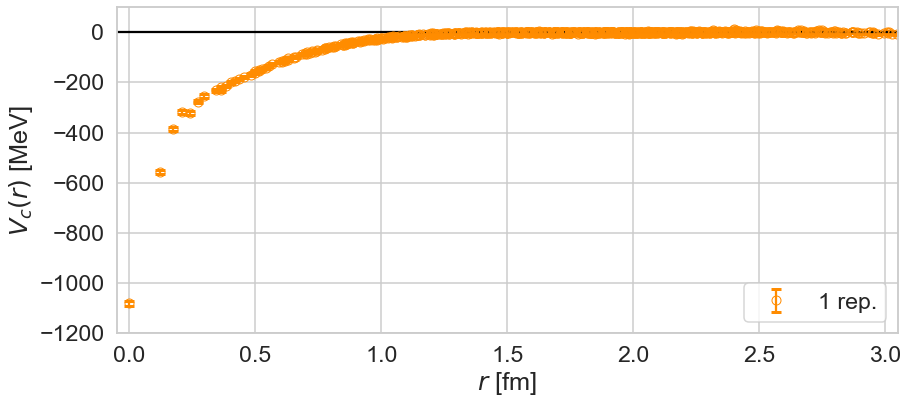

In [6]:
fig, ax = plt.subplots()
ax.errorbar(pot[:,0]*lat_unit, pot[:,1]*a_inv, pot[:,2]*a_inv, color='darkorange', fmt='o', mfc='None',
           capsize=5, capthick=3, label='1 rep.')

ax.legend()
ax.axhline(0, color='black')

ax.set(xlim=(-0.05, 3.05), ylim=(-1200, 100), xlabel=r'$r$ [fm]', ylabel=r'$V_c(r)$ [MeV]');

fit

In [7]:
import warnings
warnings.simplefilter('ignore')

In [8]:
ffit = lambda p, x: p[0] * np.exp(-p[1]*x**2) + p[2] * np.exp(-p[3]*x**2)
errf = lambda p, y, x, err: (ffit(p,x)-y)/err
pfit = scipy.optimize.leastsq(errf, [-1, 0.5, -1, 1], args=(pot[:,1], pot[:,0], pot[:,2]), full_output=True)

print('fit params: ', pfit[0])
param_fit = pfit[0]
V_fit = lambda x: param_fit[0] * np.exp(-param_fit[1]*x**2) + param_fit[2] * np.exp(-param_fit[3]*x**2)

fit params:  [-0.18899732  0.03791465 -0.46893186  1.00724437]


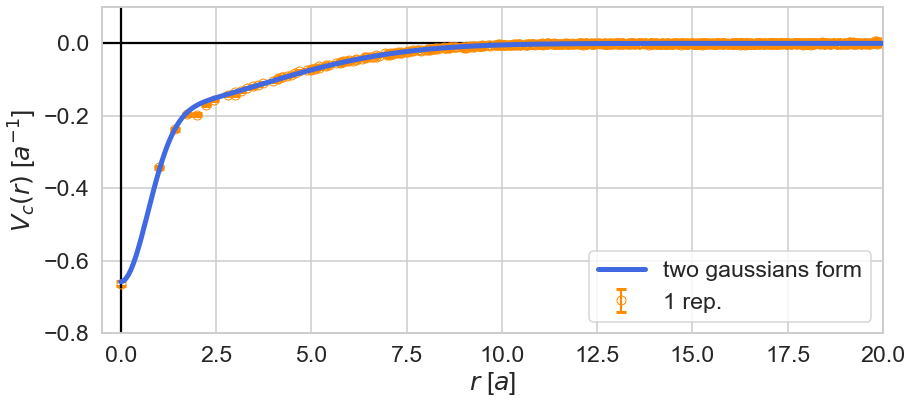

In [12]:
fig, ax = plt.subplots()
ax.errorbar(pot[:,0], pot[:,1], pot[:,2], color='darkorange', fmt='o', mfc='None',
           capsize=5, capthick=3, label='1 rep.')

xls = np.linspace(0, 20, 300)

ax.plot(xls, V_fit(xls), color='royalblue', zorder=3, lw=5,
       label='two gaussians form')

ax.legend()
ax.axhline(0, color='black')
ax.axvline(0, color='black')

ax.set(xlim=(-0.5, 20), ylim=(-0.8, 0.1), xlabel=r'$r$ [$a$]', ylabel=r'$V_c(r)$ [$a^{-1}$]');

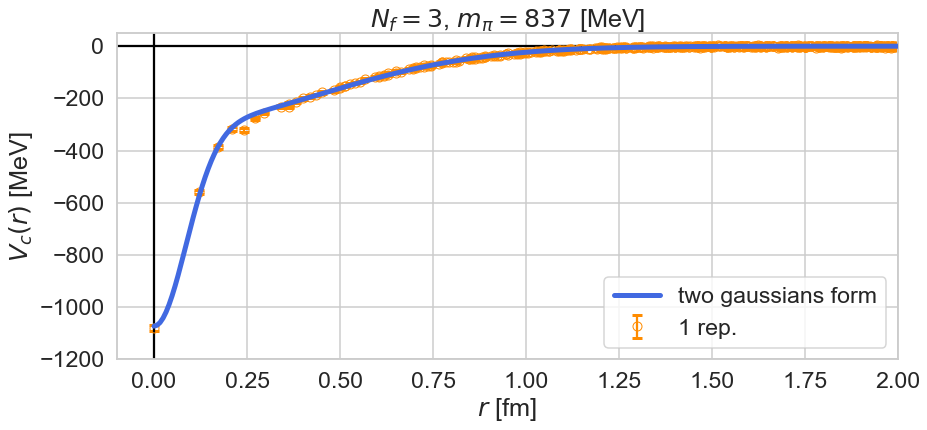

In [16]:
fig, ax = plt.subplots()
ax.errorbar(pot[:,0]*lat_unit, pot[:,1]*a_inv, pot[:,2]*a_inv, color='darkorange', fmt='o', mfc='None',
           capsize=5, capthick=3, label='1 rep.')

xls = np.linspace(0, 20, 300)

ax.plot(xls*lat_unit, V_fit(xls)*a_inv, color='royalblue', zorder=3, lw=5,
       label='two gaussians form')

ax.legend()
ax.axhline(0, color='black')
ax.axvline(0, color='black')

ax.set(xlim=(-0.1, 2), ylim=(-1200, 50), xlabel=r'$r$ [fm]', ylabel=r'$V_c(r)$ [MeV]',
      title=r'$N_f = 3$, $m_\pi = 837$ [MeV]')
fig.savefig('../figs/hal_pot_finite_volume/su3_mpi837MeV_1rep_pot.png', bbox_inches='tight')

## calc scattering phase shift & binding energy

In [10]:
class Schroedinger_Eq(object):
    """Calculate the scattering phase shifts by solving Schroedinger Eq.
    
    All parameters are in lattice unit.
    """
    def __init__(self, pot, red_mass, r_min = 1.0e-3, r_max = 1.0e2, r_diff = 1.0e-4):
        self.pot = pot
        self.rs = np.arange(r_min, r_max, r_diff)
        self.red_mass = red_mass
        
    def sch_eq(self, uv, r, k2):
        """
        u = psi(r)/r with u(0) = 0
        solve
        u'' = - 2 mu (E - V(r)) u
        -->
        u' = v
        v' = - (k^2 - 2 mu V(r)) u
        """
        du = uv[1]
        dv = - (k2 - 2 * self.red_mass * self.pot(r)) * uv[0]
        return np.array([du, dv])
        
    def conv_delta(self, r, u, u_prime, k):
        return np.mod(np.arctan(k*u/u_prime) - k*r, np.pi)
    
    def plot_asymptotic_behavior(self, k2, u_prime_ini=1.0e-4):
        """
        This method checks convergence of the phase shift.
        """
        trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini), self.rs,
                            args=(k2,))
        fig, ax = plt.subplots()
        ax.plot(self.rs, self.conv_delta(self.rs, trj[:,0], trj[:,1], np.sqrt(k2)),
               label=r'$k^2 = {}$'.format(k2))
        ax.set_xlabel(r'$r$')
        ax.set_ylabel(r'$\delta$ [rad.]')
        ax.legend()
        return ax
        
    def calc_phase_shift(self, k2, u_prime_ini=1.0e-4):
        assert k2 > 0
        trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini), self.rs,
                            args=(k2,))

        return self.conv_delta(self.rs[-1], trj[-1,0], trj[-1,1], np.sqrt(k2))
    
    def Wr(self, k2, u_prime_ini=1.0e-4):
        assert k2 < 0
        trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini), self.rs, args=(k2,))
        return trj[-1,1] + np.sqrt(-k2) * trj[-1,0]
    
    def calc_BE(self, k2_init=-0.1):
        self.k2ast = scipy.optimize.newton(self.Wr, -0.1)
        self.BE = -self.k2ast/(2*self.red_mass)
        
        print(f'B.E. = {self.BE:.2f}')
        
    def check_k2ast_conv(self, k2lim):
        k2s = np.linspace(k2lim[0], k2lim[1])
        
        fig, ax = plt.subplots()
        ax.plot(k2s, [self.Wr(k2) for k2 in k2s], marker='o')
        ax.axhline(0)
        ax.set(xlabel=r'$-k^2$', ylabel=r'$u^\prime(r) + \sqrt{-k^2}u(r)$')
        
    def calc_rms(self, u_prime_ini=1.0e-4):
        if not hasattr(self, 'k2ast'):
            self.calc_BE()
            
        trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini),
                    self.rs, args=(self.k2ast,))
        self.rms = self._root_mean_square_distance(self.rs, trj[:,0], self.k2ast)
        
    def _root_mean_square_distance(self, rs, u, k2ast):
        kappa = np.sqrt(-k2ast)
        dr = rs[1] - rs[0]
        r0 = rs[-1]
        A = u[-1] * np.exp(kappa*r0)
        nume = np.sum(rs**2*u**2)*dr + A**2/(4*kappa**3) * (
            1 + 2*r0*kappa+2*r0**2*kappa**2)*np.exp(-2*kappa*r0)
        denom = np.sum(u**2)*dr + A**2*np.exp(-2*kappa*r0)/(2*kappa)
        return np.sqrt(nume/denom)


B.E. = 0.02


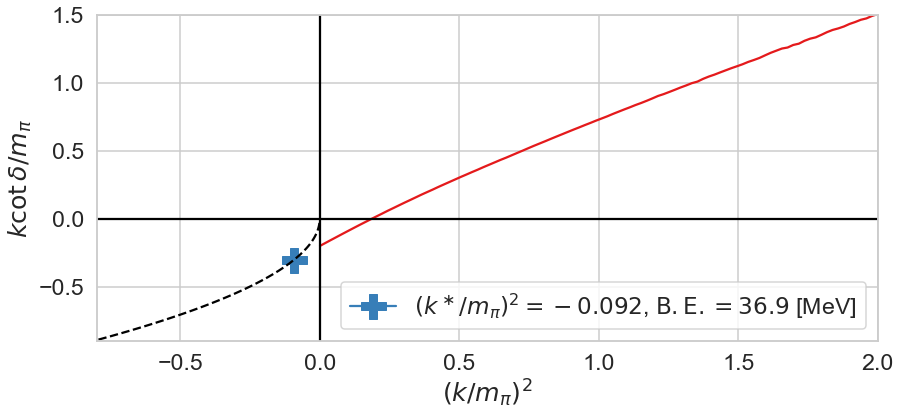

In [11]:
M_red = m_B/2 # baryon mass in this conf.

seq = Schroedinger_Eq(V_fit, M_red)

seq.calc_BE()

# phase shifts
k2mpi2s = np.linspace(1.0e-3, 2, 100)

kcotmpis = np.array([
    np.sqrt(k2mpi2)/np.tan(seq.calc_phase_shift(k2mpi2*m_pi**2))
    for k2mpi2 in k2mpi2s
])

fig, ax = plt.subplots()
ax.plot(k2mpi2s, kcotmpis)

ax.plot(seq.k2ast/m_pi**2, - np.sqrt(-seq.k2ast/m_pi**2), marker='P', ms=25,
       label=rf'$(k^\ast/m_\pi)^2 = {seq.k2ast/m_pi**2:.3f}$, $\mathrm{{B.E.}} = {seq.BE*a_inv:.1f}$ [MeV]')

k2ls = np.concatenate([np.linspace(-1, -0.05), np.linspace(-0.05,-1e-3)])
ax.plot(k2ls, - np.sqrt(-k2ls), ls='--', color='black')
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.legend()
ax.set(ylim=(-0.9, 1.5), xlim=(-0.8, 2.0), xlabel=r'$(k/m_\pi)^2$', ylabel=r'$k\cot\delta/m_\pi$');

# calc eigen values

In [82]:
def A1_projection(wave_in):
    Ns = round(len(wave_in)**(1/3))
    wave = wave_in.reshape(Ns,Ns,Ns)
    wave_tmp1 = (wave[:,:,:] + np.roll(wave,-1,0)[::-1,:,:]
                + np.roll(wave,-1,1)[:,::-1,:]
                + np.roll(wave,-1,2)[:,:,::-1]
                + np.roll(np.roll(wave,-1,0),-1,1)[::-1,::-1,:]
                + np.roll(np.roll(wave,-1,1),-1,2)[:,::-1,::-1]
                + np.roll(np.roll(wave,-1,2),-1,0)[::-1,:,::-1]
                + np.roll(np.roll(np.roll(wave,-1,0),-1,1),-1,2)[::-1,::-1,::-1])/8.0
    wave_tmp2 = (wave_tmp1 
                + np.swapaxes(wave_tmp1,0,1)
                + np.swapaxes(wave_tmp1,1,2)
                + np.swapaxes(wave_tmp1,2,0)
                + np.swapaxes(np.swapaxes(wave_tmp1,0,1),1,2)
                + np.swapaxes(np.swapaxes(wave_tmp1,0,2),2,1))/6.0e0

    return wave_tmp2.flatten()

def make_pot_data(Ns):
    Ns2 = Ns//2
    
    r_lens = np.array([np.sqrt(x**2 + y**2 + z**2) + 1.0e-5 for z in np.arange(-Ns2,Ns2)
            for y in np.arange(-Ns2, Ns2) for x in np.arange(-Ns2,Ns2)])

    
    return V_fit(r_lens), r_lens

In [227]:
class FV_spectra(object):
    def __init__(self, pot_func, red_mass):
        self.pot_func = pot_func
        self.red_mass = red_mass
    
    def make_pot_data(self, Ns):
        Ns2 = Ns//2
    
        self.r_lins = np.array([np.sqrt(x**2 + y**2 + z**2) + 1.0e-5 for z in np.arange(-Ns2,Ns2)
            for y in np.arange(-Ns2, Ns2) for x in np.arange(-Ns2,Ns2)])
        
        self.pot = self.pot_func(self.r_lins)
        
        return self.pot, self.r_lins
        

    def calc_eigen(self, Ns=48, Nev=10):
        print(f'calc. Ns = {Ns}, Nev = {Nev}')
        pot, _ = self.make_pot_data(Ns)
        
        lap = lambda vec: - 6.0*vec + ( np.roll(vec,+1,0) + np.roll(vec,-1,0) 
                              + np.roll(vec,+1,1) + np.roll(vec,-1,1) 
                              + np.roll(vec,+1,2) + np.roll(vec,-1,2) )

        Vol = Ns**3
        Umat = LinearOperator((Vol,Vol), 
                matvec = lambda vec: (pot * vec 
                  - lap(vec.reshape(Ns,Ns,Ns)).flatten()/(2.0*self.red_mass)), 
                dtype='float64')

        self.vals, self.vecs = scipy.sparse.linalg.eigsh(Umat, which='SA', k = Nev)
        
        a1norms = []
        for nth in range(Nev):
            a1 = A1_projection(self.vecs[:,nth])
            a1norms.append(np.sum(a1**2))
            print(f'{nth}: {self.vals[nth]:.3f} {np.sum(a1**2):.2f}')
        self.a1norms = np.array(a1norms)
        return self.vals, self.vecs, self.a1norms

In [377]:
class LD(object):
    def __init__(self, L, level, m_B, m_pi, dE):
        self.L = L
        self.level = level
        self.m_pi = m_pi
        self.m_B = m_B
        
        self.kcs = Kcot_luscher(self.L, self.m_B, self.m_B)
        
        self.k2 = dE * m_B
        
        self.k2mpi2 = self.k2/self.m_pi**2
        self.kcot_mpi = self.kcs.kcot(self.k2) / self.m_pi
        
    def generate_reference_line(self, xlim, ylim, dk2=0.01, point_max=2000, delta_y_limit=0.5):
        self.xlim = xlim
        self.ylim = ylim
        def _gen_reference_line(x0, y0, dk2):
            _k2mpi2_ref = [x0]
            _kcot_mpi_ref = [y0]
            for i in range(point_max):
                x1 = x0 + dk2
                y1 = self.kcs.kcot(x1 * self.m_pi**2)/self.m_pi
                
                if np.abs(y1 - y0) > delta_y_limit:
                    dk2 /= 2
                    continue
                    
                _k2mpi2_ref.append(x1)
                _kcot_mpi_ref.append(y1)
                                
                if (y1 >= ylim[1]) or (y1 <= ylim[0]):
                    break
                if (x1 >= xlim[1]) or (x1 <= xlim[0]):
                    break

                x0, y0 = x1, y1
            return _k2mpi2_ref, _kcot_mpi_ref

        _k2mpi2_ref_1, _kcot_mpi_ref_1 = _gen_reference_line(self.k2mpi2, self.kcot_mpi, dk2)
        _k2mpi2_ref_2, _kcot_mpi_ref_2 = _gen_reference_line(self.k2mpi2, self.kcot_mpi, - dk2)
        
        self.k2mpi2_ref = np.concatenate([_k2mpi2_ref_2[1:][::-1], _k2mpi2_ref_1])
        self.kcot_mpi_ref = np.concatenate([_kcot_mpi_ref_2[1:][::-1], _kcot_mpi_ref_1])

In [291]:
def calc_kcot_vs_k2(L, level, m_B, m_pi, dE, xlim, ylim):
    ld = LD(L, level, m_B, m_pi, dE)
    ld.generate_reference_line(xlim, ylim, dk2=0.001, delta_y_limit=0.1)
    
    fig, ax = plt.subplots()
    ax.plot(ld.k2mpi2, ld.kcot_mpi, 'o', ms=25, color='C1', zorder=3,
           label=f'$L = {L}$')
    ax.plot(ld.k2mpi2_ref, ld.kcot_mpi_ref, '--',color='grey')


    if xlim[0] < 0:
        xbs = np.concatenate([np.linspace(xlim[0], -1e-1), np.linspace(-1e-1, -1e-4)])
        ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-')

    ax.legend()
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set(xlabel=r'$(k/m_\pi)^2$', ylabel=r'$k\cot\delta/m_\pi$', xlim=xlim, ylim=ylim)
    
    return ld

In [364]:
fv = FV_spectra(V_fit, M_red)

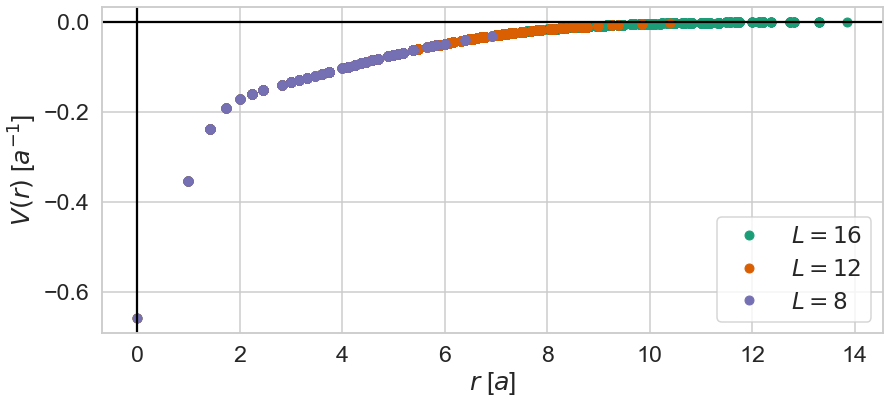

In [457]:
with sns.color_palette('Dark2'):
    fig, ax = plt.subplots()

    for L in [16, 12, 8]:
        _pot, _r = fv.make_pot_data(L)
        ax.plot(_r, _pot, marker='o', ls='', label=rf'$L = {L}$')

    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.legend()
    ax.set(xlabel=r'$r$ [$a$]', ylabel=r'$V(r)$ [$a^{-1}$]')
    fig.savefig('../figs/hal_pot_finite_volume/finite_volume_potential.png', bbox_inches='tight')

In [378]:
ld_dic = {}

In [379]:
L = 8
vals, _, a1norms = fv.calc_eigen(Ns=L, Nev=5)

calc. Ns = 8, Nev = 5
0: -0.116 1.00
1: 0.407 1.00
2: 0.433 0.00
3: 0.433 0.00
4: 0.433 0.00


In [380]:
xlim0 = (-0.8, 2)
ylim0 = (-0.9, 1.5)

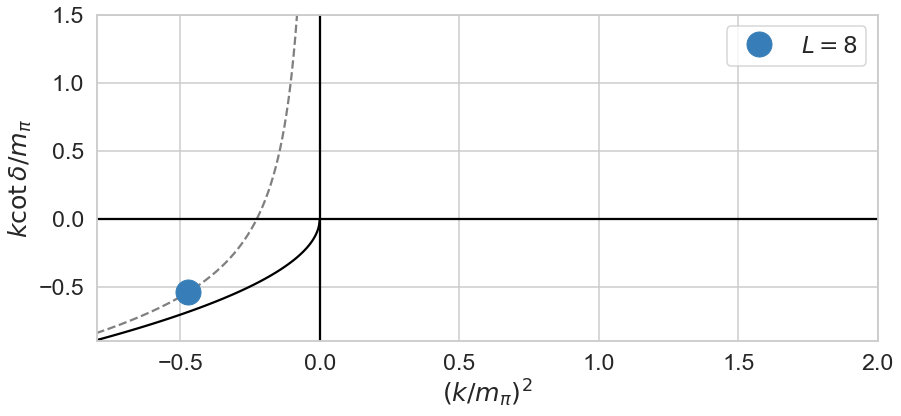

In [381]:
ld_dic[(L,0)] = calc_kcot_vs_k2(L, 0, m_B, m_pi, vals[0], xlim0, ylim0)

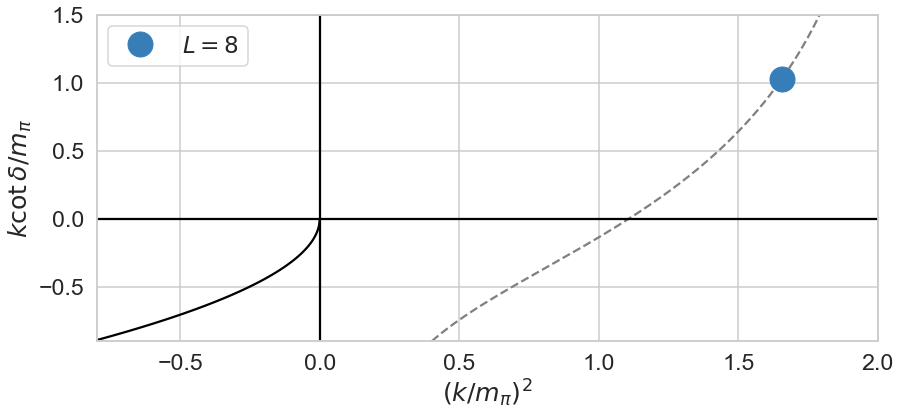

In [382]:
ld_dic[(L,1)] = calc_kcot_vs_k2(L, 0, m_B, m_pi, vals[1], xlim0, ylim0)

In [383]:
L = 12
vals, _, a1norms = fv.calc_eigen(Ns=L, Nev=5)

calc. Ns = 12, Nev = 5
0: -0.070 1.00
1: 0.161 1.00
2: 0.183 0.00
3: 0.183 0.00
4: 0.183 0.00


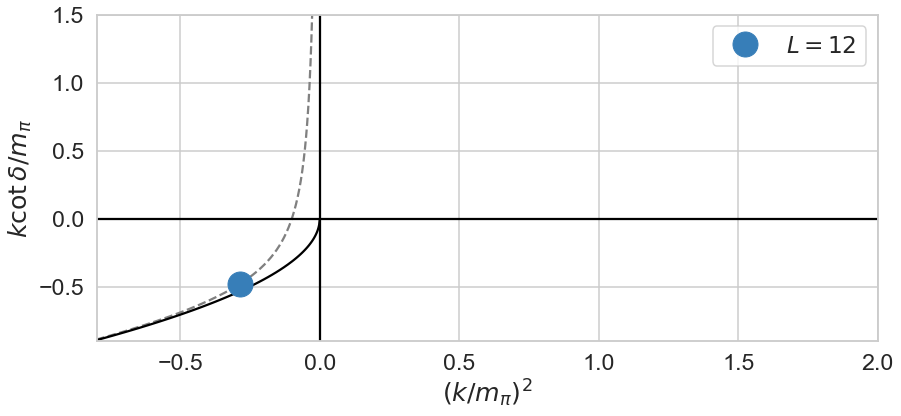

In [384]:
ld_dic[(L,0)] = calc_kcot_vs_k2(L, 0, m_B, m_pi, vals[0], xlim0, ylim0)

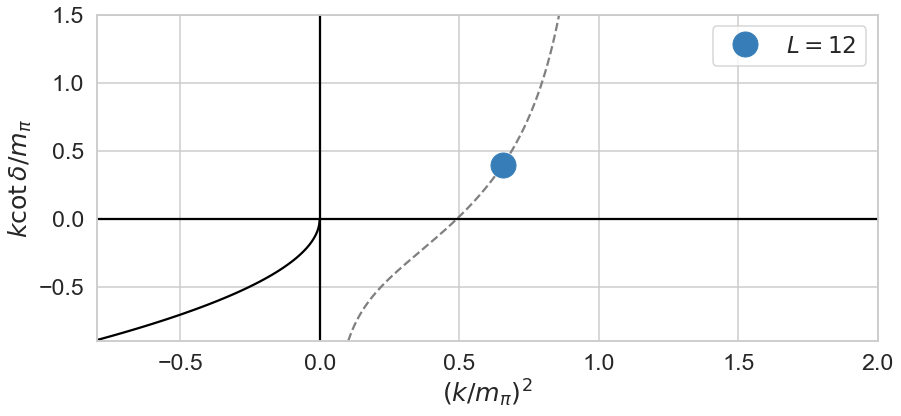

In [385]:
ld_dic[(L,1)] = calc_kcot_vs_k2(L, 1, m_B, m_pi, vals[1], xlim0, ylim0)

In [386]:
L = 16
vals, _, a1norms = fv.calc_eigen(Ns=L, Nev=5)

calc. Ns = 16, Nev = 5
0: -0.046 1.00
1: 0.078 1.00
2: 0.104 0.00
3: 0.104 0.00
4: 0.118 0.00


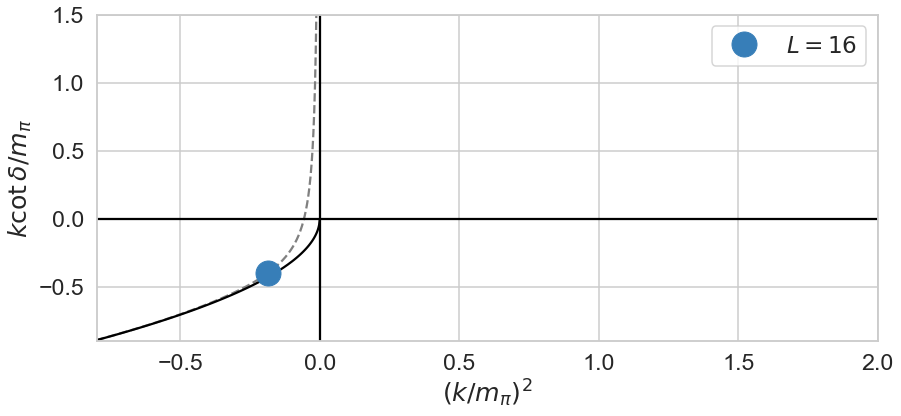

In [387]:
ld_dic[(L,0)] = calc_kcot_vs_k2(L, 0, m_B, m_pi, vals[0], xlim0, ylim0)

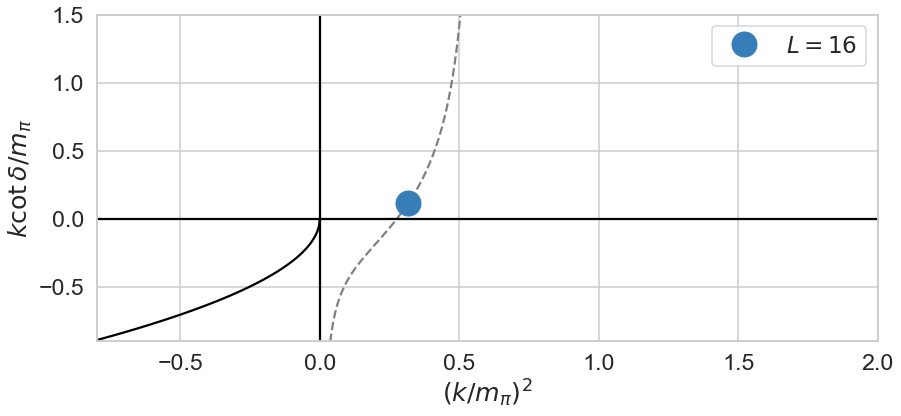

In [388]:
ld_dic[(L,1)] = calc_kcot_vs_k2(L, 0, m_B, m_pi, vals[1], xlim0, ylim0)

In [402]:
ld_dic.keys()

dict_keys([(8, 0), (8, 1), (12, 0), (12, 1), (16, 0), (16, 1)])

In [403]:
L = 24
vals, _, a1norms = fv.calc_eigen(Ns=L, Nev=5)

calc. Ns = 24, Nev = 5
0: -0.028 1.00
1: 0.023 1.00
2: 0.050 0.00
3: 0.050 0.00
4: 0.050 0.00


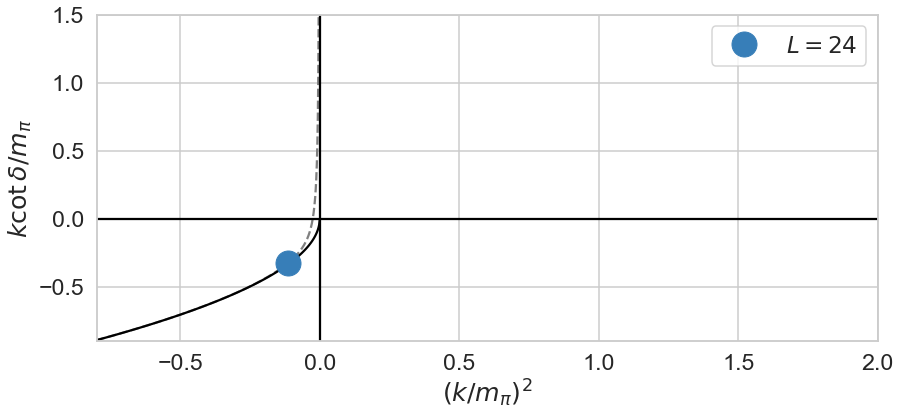

In [404]:
ld_dic[(L,0)] = calc_kcot_vs_k2(L, 0, m_B, m_pi, vals[0], xlim0, ylim0)

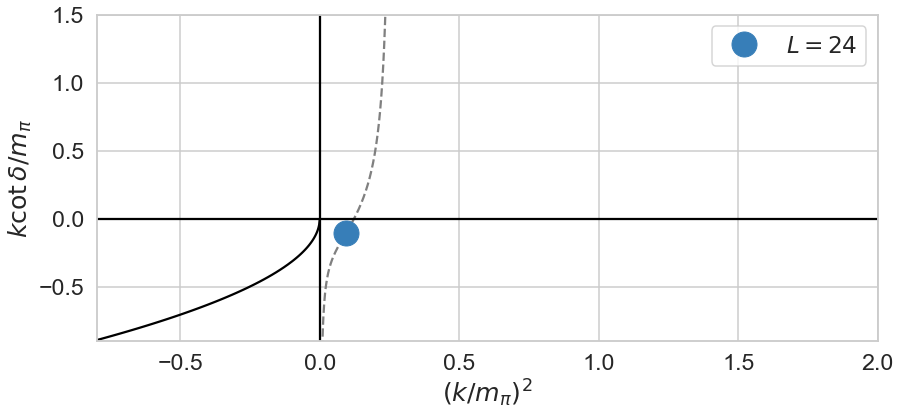

In [405]:
ld_dic[(L,1)] = calc_kcot_vs_k2(L, 0, m_B, m_pi, vals[1], xlim0, ylim0)

In [406]:
L = 32
vals, _, a1norms = fv.calc_eigen(Ns=L, Nev=5)

calc. Ns = 32, Nev = 5
0: -0.024 1.00
1: 0.009 1.00
2: 0.031 0.00
3: 0.031 0.00
4: 0.031 0.00


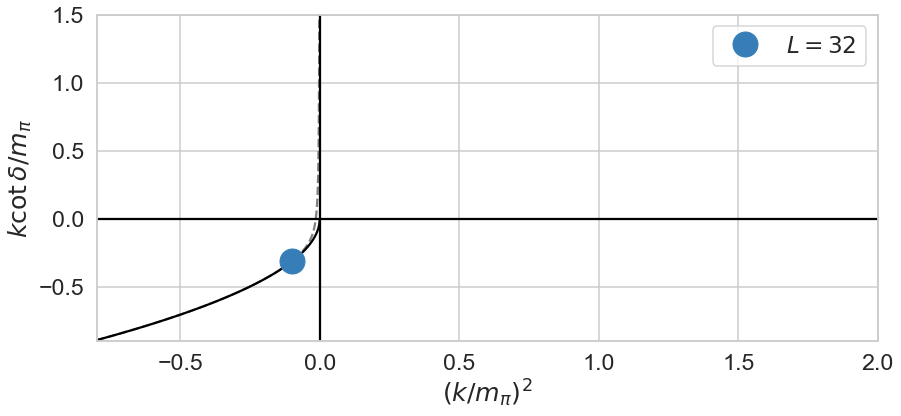

In [407]:
ld_dic[(L,0)] = calc_kcot_vs_k2(L, 0, m_B, m_pi, vals[0], xlim0, ylim0)

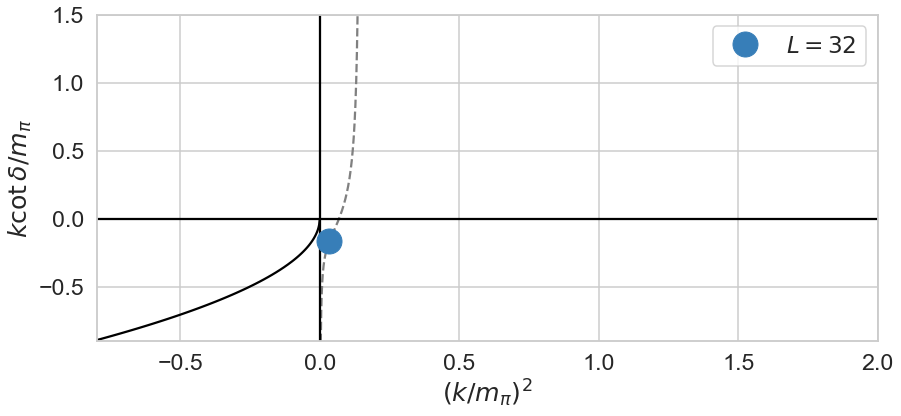

In [408]:
ld_dic[(L,1)] = calc_kcot_vs_k2(L, 0, m_B, m_pi, vals[1], xlim0, ylim0)

In [409]:
color_list = {8: 'dimgray', 12: 'firebrick', 16: 'darkorange', 24: 'mediumturquoise', 32: 'ghostwhite'}

In [454]:
m_pi*a_inv

836.5

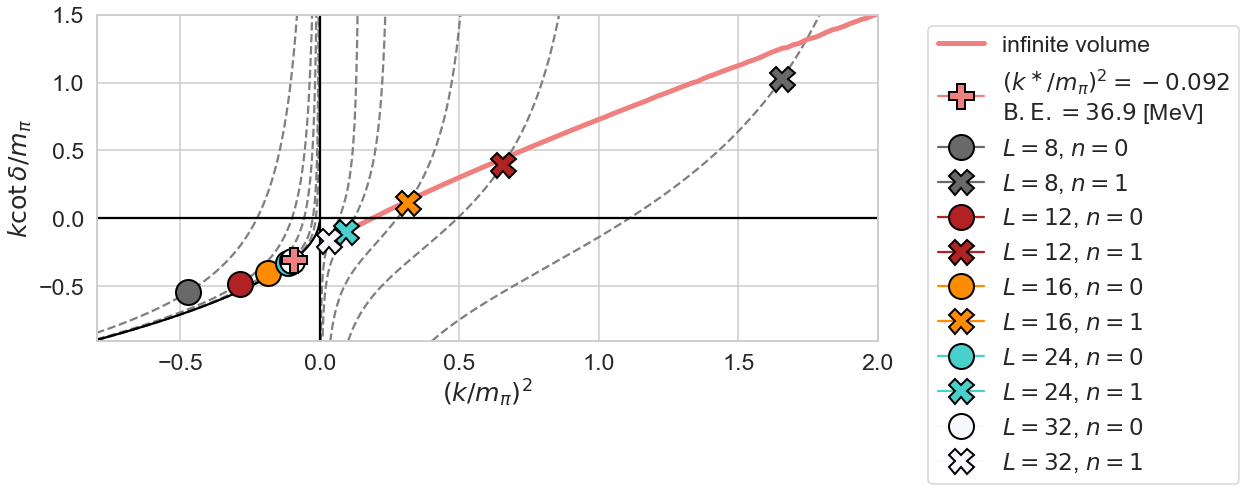

In [455]:
fig, ax = plt.subplots()
ax.plot(k2mpi2s, kcotmpis, lw=5, color='lightcoral', label='infinite volume')

ax.plot(seq.k2ast/m_pi**2, - np.sqrt(-seq.k2ast/m_pi**2), color='lightcoral', marker='P', ms=25, mec='black', mew=2,
       label=rf'$(k^\ast/m_\pi)^2 = {seq.k2ast/m_pi**2:.3f}$' + '\n' + rf'$\mathrm{{B.E.}} = {seq.BE*a_inv:.1f}$ [MeV]', zorder=5)

k2ls = np.concatenate([np.linspace(-1, -0.05), np.linspace(-0.05,-1e-3)])
ax.plot(k2ls, - np.sqrt(-k2ls), ls='-', color='black')

for key in ld_dic.keys():
    ld = ld_dic.get(key)
    c = color_list.get(key[0])
    sym = {0: 'o', 1: 'X'}[key[1]]
    ax.plot(ld.k2mpi2, ld.kcot_mpi, color=c, marker=sym, mec='black', mew=2,
            ms=25, label=f'$L = {key[0]}$, $n = {key[1]}$', zorder=3)
    ax.plot(ld.k2mpi2_ref, ld.kcot_mpi_ref, ls='--', color='grey', zorder=1)
    

ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.legend(loc='upper left', bbox_to_anchor=(1.05,1))
ax.set(ylim=ylim0, xlim=xlim0, xlabel=r'$(k/m_\pi)^2$', ylabel=r'$k\cot\delta/m_\pi$');
fig.savefig('../figs/hal_pot_finite_volume/su3_mpi837MeV_kcot_vs_k2_L_dep.png', bbox_inches='tight')

In [449]:
xs = k2mpi2s
ys = kcotmpis
mask = xs < 0.05
ere = lambda p, x: p[0] + 0.5*p[1]*x
ere_err = lambda p, y, x, err: (ere(p,x)-y)/err
ere_fit = scipy.optimize.leastsq(ere_err, [-0.2, 1], args=(ys[mask], xs[mask], np.ones_like(xs[mask])), full_output=True)

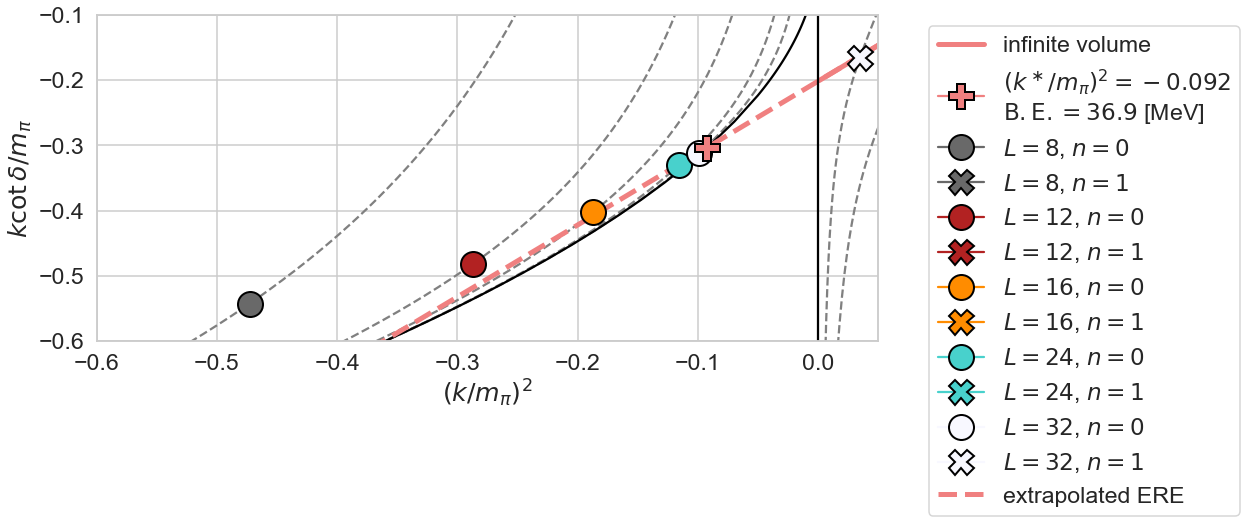

In [456]:
fig, ax = plt.subplots()
ax.plot(k2mpi2s, kcotmpis, lw=5, color='lightcoral', label='infinite volume')

ax.plot(seq.k2ast/m_pi**2, - np.sqrt(-seq.k2ast/m_pi**2), color='lightcoral', marker='P', ms=25, mec='black', mew=2,
       label=rf'$(k^\ast/m_\pi)^2 = {seq.k2ast/m_pi**2:.3f}$' + '\n' + rf'$\mathrm{{B.E.}} = {seq.BE*a_inv:.1f}$ [MeV]', zorder=5)

k2ls = np.concatenate([np.linspace(-1, -0.05), np.linspace(-0.05,-1e-3)])
ax.plot(k2ls, - np.sqrt(-k2ls), ls='-', color='black')

for key in ld_dic.keys():
    ld = ld_dic.get(key)
    c = color_list.get(key[0])
    sym = {0: 'o', 1: 'X'}[key[1]]
    ax.plot(ld.k2mpi2, ld.kcot_mpi, color=c, marker=sym, mec='black', mew=2,
            ms=25, label=f'$L = {key[0]}$, $n = {key[1]}$', zorder=3)
    ax.plot(ld.k2mpi2_ref, ld.kcot_mpi_ref, ls='--', color='grey', zorder=1)
    

    
xls = np.linspace(-0.6, 0.1)
ax.plot(xls, ere(ere_fit[0], xls), ls='--', lw=5, color='lightcoral', label='extrapolated ERE')
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.legend(loc='upper left', bbox_to_anchor=(1.05,1))
ax.set(ylim=(-0.6, -0.1), xlim=(-0.6, 0.05), xlabel=r'$(k/m_\pi)^2$', ylabel=r'$k\cot\delta/m_\pi$');

fig.savefig('../figs/hal_pot_finite_volume/su3_mpi837MeV_kcot_vs_k2_L_dep_neg.png', bbox_inches='tight')